# Final Python Notebook 3: Regression DT and Ensemble Learners

Author: Nelith Nethsanda

Uow ID:w2051741

IIT ID:20230664

Peer Reviewed By: Sonal Pathinayaka

Notebook Purpose: Explore ensemble classification and decision tree regression to predict cancer patient mortality and survival months.

 Code Reuse Session 3

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [36]:
#Load Cleaned Dataset (Leveraged from Final Notebook 1 Output)
regression_data = pd.read_csv("/content/regression_dataset.csv")

In [37]:
# Block: Prepare Regression Dataset (Drop Mortality Status)

# regression_data = data.drop(columns=['Mortality_Status', 'Patient_ID', 'Month_of_Birth', '6th_Stage'])

In [38]:
# Prepare Regression Dataset
# regression_data = data.drop(columns=['Mortality_Status', 'Patient_ID', 'Month_of_Birth', '6th_Stage'])

Xr = regression_data.drop(columns=['Survival_Months'])
Xr = pd.get_dummies(Xr)  #This line handles 'Sex', 'T_Stage', etc.

yr = regression_data['Survival_Months']
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.2, random_state=42)


In [39]:
# Block: Fully Grown Decision Tree Regressor (DT-1)
tree_full = DecisionTreeRegressor(random_state=42)
tree_full.fit(Xr_train, yr_train)


DecisionTreeRegressor(random_state=42)

In [40]:
# Predict and Evaluate
yr_pred_full = tree_full.predict(Xr_test)
mae_full = mean_absolute_error(yr_test, yr_pred_full)
mse_full = mean_squared_error(yr_test, yr_pred_full)
r2_full = r2_score(yr_test, yr_pred_full)

In [41]:
print("Fully Grown Tree Results:")
print("MAE:", mae_full)
print("MSE:", mse_full)
print("R² Score:", r2_full)

Fully Grown Tree Results:
MAE: 24.5561797752809
MSE: 976.6251560549314
R² Score: -0.8561422614381828


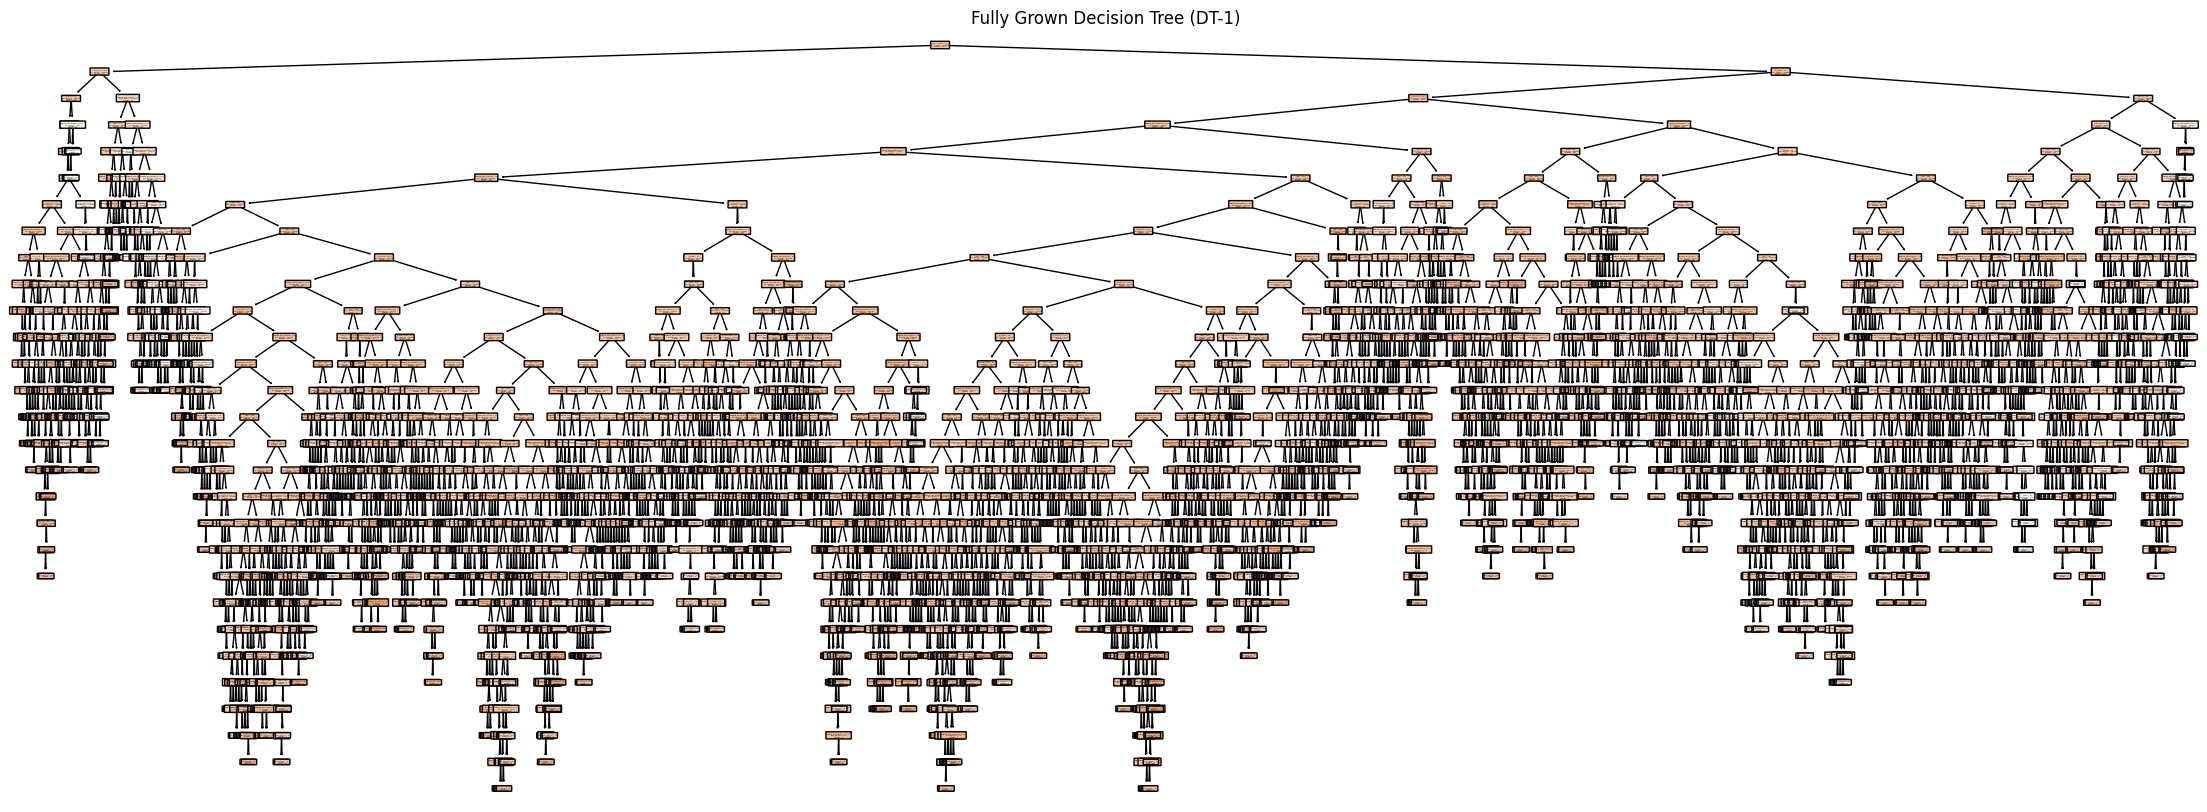

In [42]:
# Visualise DT-1
plt.figure(figsize=(28, 10))
plot_tree(tree_full, feature_names=Xr.columns, filled=True, rounded=True)
plt.title("Fully Grown Decision Tree (DT-1)")
plt.show()

In [43]:
# Block: Pruned Decision Tree Regressor (DT-2, max_depth=4)
tree_pruned = DecisionTreeRegressor(max_depth=4, random_state=42)
tree_pruned.fit(Xr_train, yr_train)

DecisionTreeRegressor(max_depth=4, random_state=42)

In [44]:
# Predict and Evaluate
yr_pred_pruned = tree_pruned.predict(Xr_test)
mae_pruned = mean_absolute_error(yr_test, yr_pred_pruned)
mse_pruned = mean_squared_error(yr_test, yr_pred_pruned)
r2_pruned = r2_score(yr_test, yr_pred_pruned)

In [45]:
print("\nPruned Tree Results:")
print("MAE:", mae_pruned)
print("MSE:", mse_pruned)
print("R² Score:", r2_pruned)



Pruned Tree Results:
MAE: 18.57563279567197
MSE: 511.63798625121734
R² Score: 0.027597350989597924


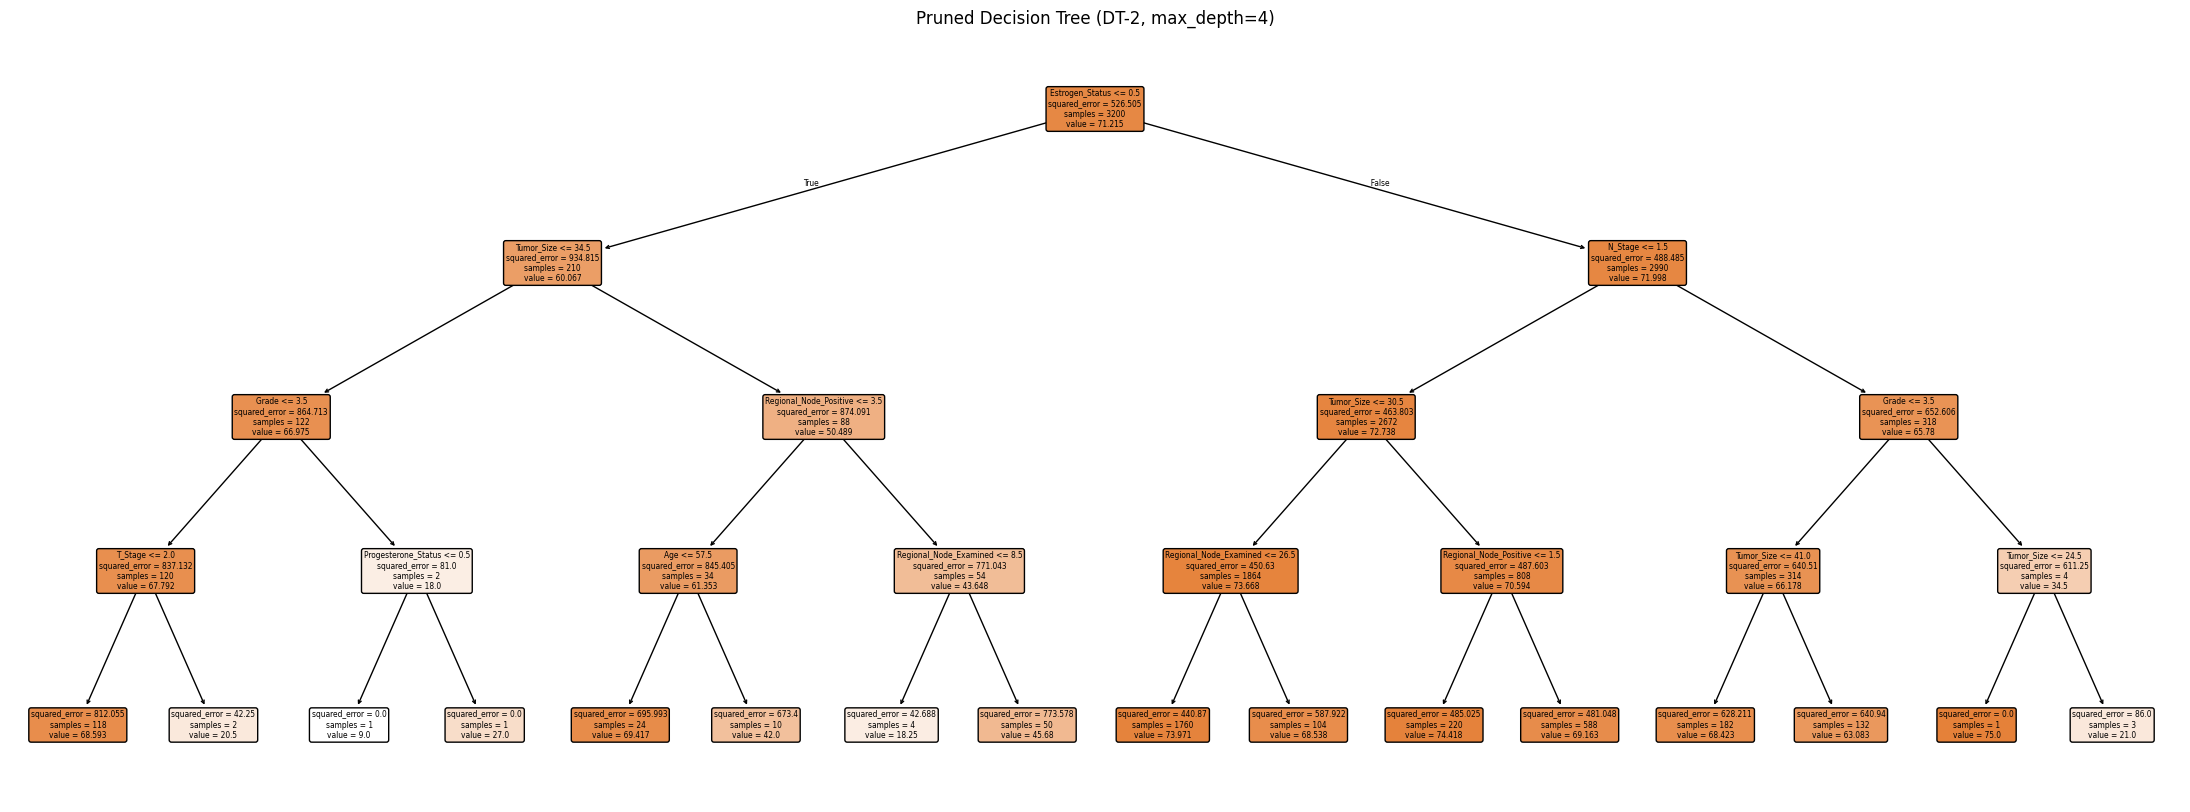

In [46]:
# Visualise DT-2
plt.figure(figsize=(28, 10))
plot_tree(tree_pruned, feature_names=Xr.columns, filled=True, rounded=True)
plt.title("Pruned Decision Tree (DT-2, max_depth=4)")
plt.show()

In [47]:
# Block: Load Classification Dataset for Ensemble Learning (Leveraged from Final Notebook 1 Output)
class_data = pd.read_csv("/content/classification_dataset.csv")
class_data = class_data.dropna(subset=['Mortality_Status'])
class_data = class_data.select_dtypes(include=[np.number])

Xc = class_data.drop(columns=['Mortality_Status'])
yc = class_data['Mortality_Status']
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.2, stratify=yc, random_state=42)

In [48]:
# Block: Ensemble Voting Classifier (Logistic Regression + Naive Bayes)

scaler = StandardScaler()
Xc_train_scaled = scaler.fit_transform(Xc_train)
Xc_test_scaled = scaler.transform(Xc_test)

lr_clf = LogisticRegression(class_weight='balanced')
nb_clf = GaussianNB()
ensemble = VotingClassifier(estimators=[('lr', lr_clf), ('nb', nb_clf)], voting='soft')
ensemble.fit(Xc_train_scaled, yc_train)


VotingClassifier(estimators=[('lr',
                              LogisticRegression(class_weight='balanced')),
                             ('nb', GaussianNB())],
                 voting='soft')


Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       678
           1       0.38      0.41      0.40       123

    accuracy                           0.81       801
   macro avg       0.64      0.64      0.64       801
weighted avg       0.81      0.81      0.81       801



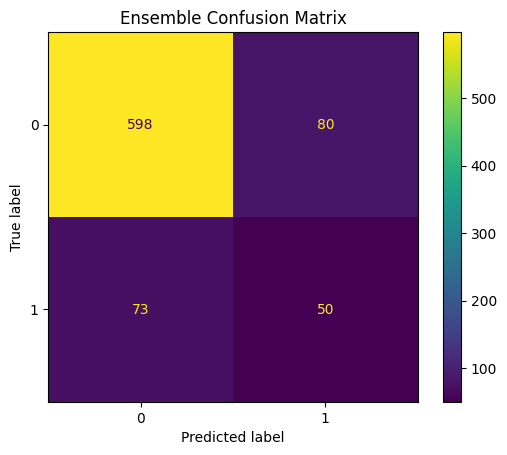

In [49]:
# Evaluate Ensemble
y_pred_ensemble = ensemble.predict(Xc_test_scaled)
print("\nEnsemble Classification Report:")
print(classification_report(yc_test, y_pred_ensemble))
ConfusionMatrixDisplay(confusion_matrix(yc_test, y_pred_ensemble)).plot()
plt.title("Ensemble Confusion Matrix")
plt.show()


ROC AUC Score (Ensemble): 0.74


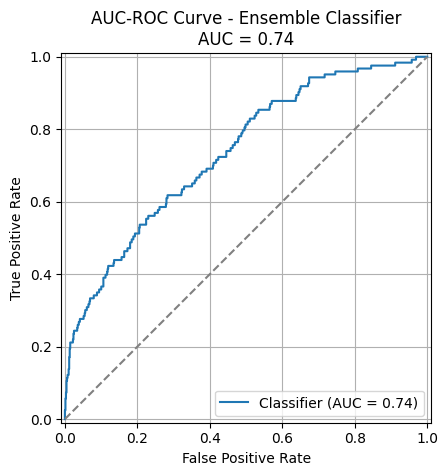

In [50]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score

# Predict probabilities for ROC curve (positive class = 1)
y_probs_ensemble = ensemble.predict_proba(Xc_test_scaled)[:, 1]

# Compute ROC AUC Score
roc_auc_ensemble = roc_auc_score(yc_test, y_probs_ensemble)
print(f"ROC AUC Score (Ensemble): {roc_auc_ensemble:.2f}")

# Plot ROC Curve
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(yc_test, y_probs_ensemble, ax=ax)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title(f"AUC-ROC Curve - Ensemble Classifier\nAUC = {roc_auc_ensemble:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.show()


In [51]:
#  Predict Survival Months for Patient B002565 using DT-2 (One-Hot Encoding Match)

# Step 1: Manually input original feature values (before encoding)
raw_input = pd.DataFrame({
    'Age': [29],
    'Sex': ['Female'],
    'T_Stage': ['T3'],
    'N_Stage': ['N1'],
    '6th_Stage': ['IIIC'],
    'Differentiated': ['Moderately differentiated'],
    'Grade': [2],
    'A_Stage': ['Regional'],
    'Tumor_Size': [41],
    'Estrogen_Status': ['Negative'],
    'Progesterone_Status': ['Positive'],
    'Regional_Node_Examined': [5],
    'Regional_Node_Positive': [1]
})

# Step 2: One-hot encode patient input to match training data
input_encoded = pd.get_dummies(raw_input)

# Step 3: Align input columns with Xr_train (add missing columns)
for col in Xr_train.columns:
    if col not in input_encoded.columns:
        input_encoded[col] = 0

# Step 4: Ensure correct column order
input_encoded = input_encoded[Xr_train.columns]

# Step 5: Predict survival months
predicted_survival = tree_pruned.predict(input_encoded)
print(f"\n Predicted Survival Months for Patient B002565: {predicted_survival[0]:.1f}")






 Predicted Survival Months for Patient B002565: 69.4
